In [846]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import Imputer
from difflib import SequenceMatcher
import seaborn as sns
from statistics import mean 
from ast import literal_eval
from scipy import stats

In [847]:
### Initiating Exploratory Data Analyses and Stats of the Fukushima Boar Project ###

# Aim of the project is to use (>200) wild boar roaming the contaminated areas around Fukushima as proxies for humans.
# In doing so, by evaluating the health of boars we can evaluate whether the areas are safe for humans to reinhabit.
# We'll look at a few biometrics in these boars:

# Telomere Length
# Cortisol levels
# Dicentric chromosome freqs
# External / internal dose
# Psuedo-pelger hewitt anomalies

# The data collected for this project was accumulated over >3 years by 3 graduate students:
# Kelly Cunningham
# Joshua Hayes
# Aryn Bordman

# I (Jared Luxton) am responsible for merging/synthesizing and analyzing the data. Because the data is from different people
# over long periods of time, it's fragmented into different files/formats and naming conventions. As well, some analyses/measurements
# are available for some boar but not others. It's unknown how many boar will have a complete set of measurements.
# Hence, the first objective(s) are to merge and clean the data. Because all analysis files will contain sample IDs,
# my strategy for merging the data will be to create a consistent format for sample ID in each file, allowing
# the dataframes to be merged on sample ID.

In [848]:
for file in os.scandir('.'):
    if 'boar snake master template' in file.name:
        try:
            ### Make dataframe from Excel file containing Fukushima boar data from Aryn
            df = pd.read_excel(file, sheet_name=0)
            
            ###And a dataframe for Fukushima snake data from Aryn
            snake_df = pd.read_excel(file, sheet_name=1)
            print('success loading Fukushima data')
        
        except:
            print(f'error loading boar/snake data...OTHER files {file.name}')
            
    if 'boar cortisol' in file.name:
        try:
            ###Make dataframe from cortisol values; some shared sample IDs with the boar df
            cortisol_df = pd.read_excel(file, sheet_name=0)
            print('success loading boar cortisol data')
        except:
            print(f'error loading cortisol data...{file.name}')

success loading boar cortisol data
success loading Fukushima data


In [849]:
df.head(3)

,Exposure Status,Sample ID,Sex,Age,Age Class,Estimated Age (months),External Dose (uSv),Internal Dose (uSv),qPCR ID,Concentration (ng/mcL),260/280,Normalized T/A Average (Average Telomere Length),Cortisol,Dicentrics (TC-FISH),PH anomalies
0,Control,180526C3,M,NaN,Yearling,15,0.38,NaN,C1,14.5,1.90,0.910559,NaN,NaN,NaN
1,Control,180528C2,F,NaN,Juv,8,-,NaN,C2,17.3,1.73,0.985085,NaN,NaN,NaN
2,Control,180604C2,F,NaN,Yearling,18,0.46,NaN,C3,15.8,1.90,1.117980,NaN,NaN,NaN


In [850]:
snake_df.head(3)

,Sample ID,Concentration (ng/mcL),260/280,Sex,External Dose (uSv),Internal Dose (uSv),Telomere Length
0,CEC10,19.3,1.96,F,0.10,NaN,0.444298
1,CEC18,63.7,1.83,F,0.16,NaN,0.826190
2,CEC22,45.5,1.88,F,0.17,NaN,2.067214


In [851]:
cortisol_df.head(3)

,Biel #,Date Received,Sample Number (electronic sheet),Sample ID,Hair wt (mg),Cortisol (pg/mg),Re-run,MeOH Color,pH optimal for assay,Hair Type,Hair Length (cm),Color,Comments,"Worked on sample, but not able to process",Hair Took Extra Time,Repeats
0,1,43518,160804-1,160804-1,17.19,22.990111,N,N,normal,"course, short",3.81,black scalp and tip ends with tan middle,0,0,0,0
1,2,43518,161215 T-1,161215 T-1,25.28,29.120000,N,N,normal,course with split ends,5.02,black with tan tips and scalp end,0,0,0,0
2,3,43518,161215 T-2,161215 T-2,15.85,27.255521,N,N,normal,course with split ends,5.88,black with brown tips,0,0,0,0


In [853]:
### Initial pass at cleaning boar data ' df ' from aryn 

# Cleaning boar data, making missing values NaN
df = df.replace('-', np.NaN)

# CREATE NUMERICAL REPRESENTATIONS, ALA DUMMY VARIABLES, OF EXPOSURE STATUS .. homogenize sample ids
dummies = pd.get_dummies(df['Exposure Status'], prefix='Encoded', drop_first=True)
df['Encoded Exposed'] = dummies['Encoded_Exposed']

# this function cleans 'Sample ID's by removing whitespace & dashes
def remove_dashes_space_sampleIDs(df):
    sample_id_cleaned = []
    for row in df['Sample ID']:
        if '-' in str(row):
            row = str(row).replace('-', '').replace(' ', '')
            sample_id_cleaned.append(row)
        elif ' ' in str(row):
            row = str(row).replace(' ', '')
            sample_id_cleaned.append(row)
        elif row == 'nan':
            continue
        else:
            sample_id_cleaned.append(str(row))
            continue
    return sample_id_cleaned

# cleaning 'Sample ID'
df['Sample ID'] = remove_dashes_space_sampleIDs(df)

In [854]:
### Preparing to merge cortisol data values w/ sample IDs in main boar df 

cortisol_df_samples = pd.DataFrame(cortisol_df['Sample ID'])
cortisol_df_samples['Sample Number (electronic sheet)'] = cortisol_df['Sample Number (electronic sheet)']
cortisol_df_samples['Cortisol (pg/mg)'] = cortisol_df['Cortisol (pg/mg)']

cortisol_df_samples.iloc[14, 0] = cortisol_df_samples.iloc[14,1]
cortisol_df_samples['Sample ID'] = cortisol_df_samples['Sample ID'].astype('str')

### CLEANING SAMPLE IDs IN CORTISOL DATA
        
cortisol_df_samples['Sample ID'] = remove_dashes_space_sampleIDs(cortisol_df)

### MERGING CORTISOL DATA W/ BOAR DATA via SAMPLE ID

merged_df_cortisol = df.merge(cortisol_df_samples, on=['Sample ID'])
aryn_teloPCR_cort_rad = merged_df_cortisol.drop(axis=1, labels=['Concentration (ng/mcL)','260/280', 'qPCR ID', 'Cortisol'])

In [855]:
### Making radiation exposure status of snakes more readable

Exposure_Status = []
for row in snake_df['Sample ID']:
    if row.startswith('C'):
        Exposure_Status.append('Control')
    elif row.startswith('E'):
        Exposure_Status.append('Exposed')
snake_df['Exposure Status'] = Exposure_Status

### making dummy variables for snake exposure status
snake_dum = pd.get_dummies(snake_df['Exposure Status'], prefix='Encoded', drop_first=True)
snake_df['Encoded Exposed'] = snake_dum

In [857]:
aryn_teloPCR_cort_rad.head(3)

,Exposure Status,Sample ID,Sex,Age,Age Class,Estimated Age (months),External Dose (uSv),Internal Dose (uSv),Normalized T/A Average (Average Telomere Length),Dicentrics (TC-FISH),PH anomalies,Encoded Exposed,Sample Number (electronic sheet),Cortisol (pg/mg)
0,Control,180612C1,M,NaN,Yearling,15.0,0.27,NaN,1.260040,NaN,NaN,0,180612-C1,6.134715
1,Control,180604C1,M,NaN,Juv,8.0,0.22,NaN,1.251346,NaN,NaN,0,180604-C1,9.372937
2,Control,180627C2,M,NaN,Juv+,10.0,0.20,NaN,1.382618,NaN,NaN,0,180627-C2,13.472222


In [858]:
snake_df.head()

,Sample ID,Concentration (ng/mcL),260/280,Sex,External Dose (uSv),Internal Dose (uSv),Telomere Length,Exposure Status,Encoded Exposed
0,CEC10,19.3,1.96,F,0.10,NaN,0.444298,Control,0
1,CEC18,63.7,1.83,F,0.16,NaN,0.826190,Control,0
2,CEC22,45.5,1.88,F,0.17,NaN,2.067214,Control,0
3,CEC23,32.6,1.83,F,0.20,NaN,1.389182,Control,0
4,CEC3,NaN,1.83,M,0.09,NaN,NaN,Control,0


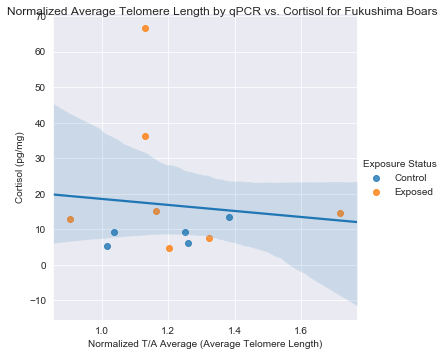

In [859]:
#Use lmplot to plot scatter points
# Create lmplot
ag = sns.lmplot(x='Normalized T/A Average (Average Telomere Length)', y='Cortisol (pg/mg)', hue='Exposure Status', 
                data=aryn_teloPCR_cort_rad, fit_reg=False)

# Access the figure & add title
fig = ag.fig
fig.suptitle("Normalized Average Telomere Length by qPCR vs. Cortisol for Fukushima Boars", fontsize=12)

#Use regplot to plot the regression line for the whole points
sns.regplot(x='Normalized T/A Average (Average Telomere Length)', y='Cortisol (pg/mg)', 
            data=aryn_teloPCR_cort_rad, scatter=False, ax=ag.axes[0, 0])

# plt.savefig(f'Normalized Average Telomere Length by qPCR vs. Cortisol for Fukushima Boars.pdf')

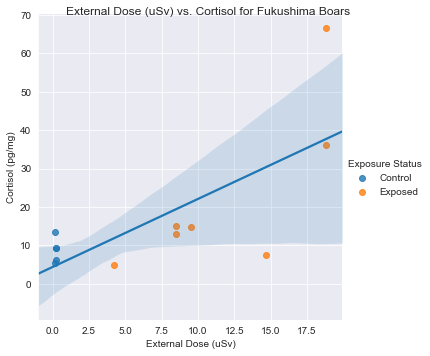

In [639]:
#Use lmplot to plot scatter points
# graph = sns.lmplot(x='x_value', y='y_value', hue='water_value', data=df, fit_reg=False)
#Use regplot to plot the regression line for the whole points
# sns.regplot(x='x_value', y='y_value', data=df, scatter=False, ax=graph.axes[0, 0]))

# Create lmplot
ag = sns.lmplot(x='External Dose (uSv)', y='Cortisol (pg/mg)', hue='Exposure Status', 
                data=aryn_teloPCR_cort_rad, fit_reg=False)
# Access the figure
fig = ag.fig

# Add title to Figure
fig.suptitle("External Dose (uSv) vs. Cortisol for Fukushima Boars", fontsize=12)

sns.regplot(x='External Dose (uSv)', y='Cortisol (pg/mg)', 
            data=aryn_teloPCR_cort_rad, scatter=False, ax=ag.axes[0, 0])

plt.savefig(f'External Dose (uSv) vs. Cortisol for Fukushima Boars.pdf')

# let's try a violin plot next!!

Sex  Exposure Status
F    Control             5
     Exposed            13
M    Control             8
     Exposed            20
dtype: int64

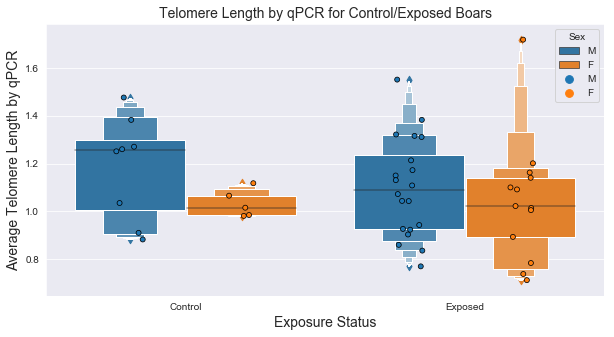

In [926]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,5))
ax = sns.boxenplot(x='Exposure Status', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df)
ax = sns.stripplot(x='Exposure Status', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df, 
                   dodge=True, edgecolor='black', linewidth=.75)
ax=fig.gca()
ax.set_title('Telomere Length by qPCR for Control/Exposed Boars', fontsize=14)
ax.set_xlabel('Exposure Status', fontsize=14)
ax.set_ylabel('Average Telomere Length by qPCR', fontsize=14)

df.groupby(by=['Sex', 'Exposure Status']).size()

#GREATER EFFECT OF RADIATION ON FEMALE BOAR? sample size?

# >>> ax = sns.boxplot(x="tip", y="day", data=tips, whis=np.inf)
# >>> ax = sns.stripplot(x="tip", y="day", data=tips,
# ...                    jitter=True, color=".3")

In [861]:
### Next.. let's work on grabbing Kelly's telomere length by Fluoresence Intensity Hybridiziation (FISH) files

# This function allows us to rescue telomere signals lost during the telomere FISH imaging / quantification process.
# where telomeres (both long & short) are lost at random. This function randomly samples observed telomere length values
# up to the maximum theoretical number of telos, given n # of cells & # telos per cell 

def gen_missing_values_andimpute_or_randomsampledown(n_cells, telosPercell, df):
    
    max_telos = n_cells * telosPercell
    half_telos = (n_cells * telosPercell) / 2

    if df.size > max_telos:
        df_sampled = df.sample(max_telos)
        return df_sampled

    if df.size > 25 and df.size <= half_telos:
        missing_data_difference = abs( (n_cells * telosPercell) - df.size )
        rsampled = df.sample(missing_data_difference, replace=True, random_state=28)
        concat_ed = pd.concat([rsampled, df], sort=False)
        np.random.shuffle(concat_ed.to_numpy())
        return concat_ed

    if df.size > 25 and df.size < max_telos:
        missing_data_difference = abs( (n_cells * telosPercell) - df.size )
        rsampled = df.sample(missing_data_difference, random_state=28)
        concat_ed = pd.concat([rsampled, df], sort=False)
        np.random.shuffle(concat_ed.to_numpy())
        return concat_ed
    
    else:
        return df

# axis labels of values within the telomere length excel values that are NOT
# telomere length values 
labels=[6, 172, 338, 504, 670, 836, 1002, 1168, 1334, 1500, 1666, 1832, 
1998, 2164, 2330, 2496, 2662, 2828, 2994, 3160, 3326, 3492, 3658, 3824,
3990, 4156, 4322, 4488, 4654, 4820]

labels_offset_by6 = [(x-6) for x in labels]

def clean_individ_telos(telo_data):
    telo_data = telo_data.drop(labels_offset_by6)
    telo_data = pd.to_numeric(telo_data.iloc[:,0], errors='coerce')
    telo_data = telo_data.dropna(axis=0, how='any')
    telo_data = telo_data.to_frame(name=None)
    telo_data = telo_data[(np.abs(stats.zscore(telo_data)) < 3).all(axis=1)]
    telo_data = pd.Series(telo_data.iloc[:,0])
    telo_data = gen_missing_values_andimpute_or_randomsampledown(30, 160, telo_data)
    return telo_data

In [862]:
# FUNCTION FOR PULLING KELLY'S TELOFISH DATA FOR 40 BOARS into a LIST.. TO BE MADE INTO A DATAFRAME & JOINED W/ MAIN DATAFRAME if possible
# These excel files take forever to load.. the objective here is to synthesize all the excel files for 
# telomere FISH data into one dataframe, then save that dataframe to csv file to be retrieved later
# loading one whole csv file containing all the data will be much, much faster than loading the parts of the whole 
# Along the way, we'll normalize the teloFISH data using controls internal to each excel file

def extract_boar_teloFISH_as_list(path):
    boar_teloFISH_list = []
    for file in os.scandir(path):
        if 'Hyb' in file.name:
            print(f'Handling {file.name}...')
            telo_excel_dict = pd.read_excel(file.name, sheet_name=None, skiprows=4, usecols=[3], nrows=5000)
            if 'Telomere Template' in telo_excel_dict.keys():
                del telo_excel_dict['Telomere Template']

            excel_file_list = []
            for sample_id, telos in telo_excel_dict.items():
                telos_cleaned = clean_individ_telos(telos)

                if sample_id != 'Control': 
                    excel_file_list.append([sample_id, telos_cleaned.values, np.mean(telos_cleaned)]) 
                elif sample_id == 'Control':
                    control_value = np.mean(telos_cleaned)

            
            #normalize teloFISH values by control value 
            for sample in excel_file_list:
                #normalize individual telos
                sample[1] = np.divide(sample[1], control_value)
                
                #normalize telo means
                sample[2] = np.divide(sample[2], control_value)
                boar_teloFISH_list.append(sample)
#                 print(f'{sample[0]} finished..')
            
    print('Finished collecting boar teloFISH data')
    return boar_teloFISH_list


In [863]:
boar_teloFISH_list = extract_boar_teloFISH_as_list('.')

Handling Telomeres - Fukushima Hyb 4 complete.xlsx...
Handling Telomeres - Fukushima Hyb 3 complete.xlsx...
Handling Telomeres - Fukushima Hyb 6 completed.xlsx...
Handling Meredith -- Telomeres - Fukushima Hyb 2.xlsx...
Handling Telomeres - Fukushima Hyb 1 complete.xlsx...
Handling Telomeres - Fukushima Hyb 5 complete.xlsx...
Finished collecting boar teloFISH data


In [793]:
### putting all of kelly's boar telomere FISH data into one dataframe
initial_boar_teloFISH_df = pd.DataFrame(boar_teloFISH_list, columns=['Sample ID', 'TeloFISH telos', 'TeloFISH Means'])

# turning the teloFISH data, which is a series in each row containing 4800 individial telomere lengths, 
# into a list in each row so that it's saved & loaded properly
# *** saving/loading teloFISH data as dataframe, series, or np.array was throwing issues w/ data integrity
initial_boar_teloFISH_df['TeloFISH telos'] = initial_boar_teloFISH_df['TeloFISH telos'].apply(lambda row: row.tolist())

# saving data to csv file for later retrieval
copy = initial_boar_teloFISH_df
copy.to_csv('boar_teloFISH.csv')
boar_teloFISH_df = pd.read_csv('boar_teloFISH.csv', index_col=0)

# retrieving data & returning teloFISH data to np.arrays from lists using literal eval
boar_teloFISH_df['TeloFISH telos'] = boar_teloFISH_df['TeloFISH telos'].apply(lambda row: np.array(literal_eval(row)))


In [794]:
def remove_dashes_space_sampleIDs(df):
    sample_id_cleaned = []
    for row in df['Sample ID']:
        if '-' in row:
            row = row.replace('-', '').replace(' ', '')
            sample_id_cleaned.append(row)
        elif ' ' in row:
            row = row.replace(' ', '')
            sample_id_cleaned.append(row)
        else:
            sample_id_cleaned.append(row)
            continue
    return sample_id_cleaned

boar_teloFISH_df['Sample ID'] = remove_dashes_space_sampleIDs(boar_teloFISH_df)

In [844]:
# sns.distplot(boar_teloFISH_df['TeloFISH telos'][0], bins=40)

fig = plt.figure(figsize=(15,15))
sns.barplot(y='Sample ID', x='TeloFISH Means', data=boar_teloFISH_df)

ax=fig.gca()

<Figure size 1080x1080 with 0 Axes>

In [845]:
boar_teloFISH_df.head()

,Sample ID,TeloFISH telos,TeloFISH Means
0,1606103,"[0.20666109674671682, 0.3183697976908881, 0.36...",0.439557
1,1607205,"[0.21224653179392539, 0.2736863173132196, 0.32...",0.452469
2,1607221,"[0.3016134925492624, 0.7484482963259474, 0.781...",0.533217
3,1607231,"[0.4635911089183107, 0.7987172117508244, 0.491...",0.583101
4,1607262,"[1.0053783084975412, 0.7484482963259474, 0.223...",0.838296


In [372]:
### MERGING KELLY TELOFISH DATA W/ CORTISOL DATA
kelly_teloF_cort = boar_teloFISH_df.merge(cortisol_df_samples, on=['Sample ID'])

# !nice! have some hits
print(kelly_teloF_cort.shape)
kelly_teloF_cort.corr()

(18, 5)


,TeloFISH Means,Cortisol (pg/mg)
TeloFISH Means,1.000000,0.622718
Cortisol (pg/mg),0.622718,1.000000


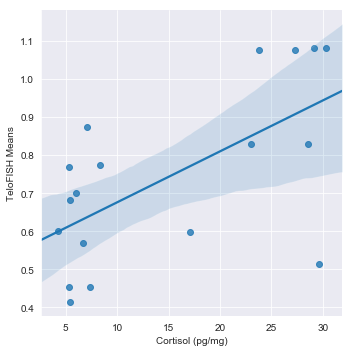

In [874]:
sns.lmplot(y='TeloFISH Means', x='Cortisol (pg/mg)', data=kelly_teloF_cort)

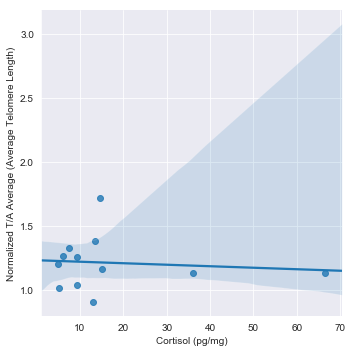

In [898]:
sns.lmplot(y='Normalized T/A Average (Average Telomere Length)', x='Cortisol (pg/mg)', data=aryn_teloPCR_cort_rad)

In [879]:
df.head()

,Exposure Status,Sample ID,Sex,Age,Age Class,Estimated Age (months),External Dose (uSv),Internal Dose (uSv),qPCR ID,Concentration (ng/mcL),260/280,Normalized T/A Average (Average Telomere Length),Cortisol,Dicentrics (TC-FISH),PH anomalies,Encoded Exposed
0,Control,180526C3,M,NaN,Yearling,15.0,0.38,NaN,C1,14.5,1.90,0.910559,NaN,NaN,NaN,0
1,Control,180528C2,F,NaN,Juv,8.0,NaN,NaN,C2,17.3,1.73,0.985085,NaN,NaN,NaN,0
2,Control,180604C2,F,NaN,Yearling,18.0,0.46,NaN,C3,15.8,1.90,1.117980,NaN,NaN,NaN,0
3,Control,180612C1,M,NaN,Yearling,15.0,0.27,NaN,C4,13.1,1.60,1.260040,NaN,NaN,NaN,0
4,Control,180627C1,M,NaN,Juv+,10.0,0.32,NaN,C5,6.2,1.70,1.476052,NaN,NaN,NaN,0


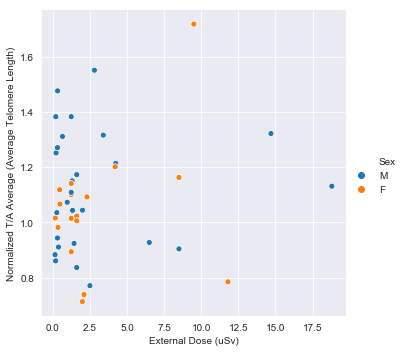

In [902]:
sns.relplot(x='External Dose (uSv)', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df)

In [883]:
### ACQUIRING KELLY DICENTRIC DATA

kelly_dicentrics = pd.read_excel('Fukushima Dicentrics.xlsx')
kelly_dicentrics.rename(columns={'Pig ID': 'Sample ID'}, inplace=True)
   
kelly_dicentrics['Sample ID'] = remove_dashes_space_sampleIDs(kelly_dicentrics)
kelly_dicentrics['Dicentrics per 100 Cells'] = kelly_dicentrics['Dicentrics']/kelly_dicentrics['Total Scored']
kelly_dicentrics.drop(['Dicentric Images', 'Notes', 'Dicentrics', 'Total Scored'], axis=1, inplace=True)



In [884]:
print(kelly_dicentrics.shape)
kelly_dicentrics.head(3)

(41, 2)


,Sample ID,Dicentrics per 100 Cells
0,1607261,0.01
1,1608012,0.03
2,1606101,0.04


In [885]:
### MERGE KELLY TELOFISH DATA W/ DICENTRICS

kelly_teloF_dicent = boar_teloFISH_df.merge(kelly_dicentrics[['Sample ID', 
                                                              'Dicentrics per 100 Cells']], on=['Sample ID'])
print(kelly_teloF_dicent.shape)
kelly_teloF_dicent.head()

(40, 4)


,Sample ID,TeloFISH telos,TeloFISH Means,Dicentrics per 100 Cells
0,1606103,"[0.20666109674671682, 0.3183697976908881, 0.36...",0.439557,0.00
1,1607205,"[0.21224653179392539, 0.2736863173132196, 0.32...",0.452469,0.00
2,1607221,"[0.3016134925492624, 0.7484482963259474, 0.781...",0.533217,0.01
3,1607231,"[0.4635911089183107, 0.7987172117508244, 0.491...",0.583101,0.01
4,1607262,"[1.0053783084975412, 0.7484482963259474, 0.223...",0.838296,0.01


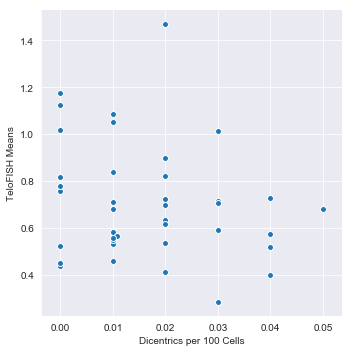

In [896]:
sns.relplot(x='Dicentrics per 100 Cells', y='TeloFISH Means', data=kelly_teloF_dicent, linewidth=1)

### MERGE KELLY DICENTRICS W/ MERGED TELOFISH + CORTISOL DATA

kelly_teloF_dicent_cort = kelly_dicentrics.merge(kelly_teloF_cort, on=['Sample ID'])
kelly_teloF_dicent_cort.drop(['Sample Number (electronic sheet)'], axis=1, inplace=True)

In [871]:
print(kelly_teloF_dicent_cort.shape)
kelly_teloF_dicent_cort.head(3)

(18, 5)


,Sample ID,Dicentrics per 100 Cells,TeloFISH telos,TeloFISH Means,Cortisol (pg/mg)
0,1607261,0.01,"[1.659096068906892, 0.21927957248291038, 0.275...",0.568116,6.736842
1,161216O247,0.01,"[1.0954844865022864, 0.4895543943804511, 0.173...",0.452690,5.360000
2,161216O247,0.01,"[1.0954844865022864, 0.4895543943804511, 0.173...",0.452690,7.394297


In [893]:
kelly_teloF_dicent_cort.corr()

,Dicentrics per 100 Cells,TeloFISH Means,Cortisol (pg/mg)
Dicentrics per 100 Cells,1.000000,-0.344701,-0.054393
TeloFISH Means,-0.344701,1.000000,0.622718
Cortisol (pg/mg),-0.054393,0.622718,1.000000


In [498]:
### ACQUIRING KELLY BOAR AGE, SEX DATA
kelly_age_sex = pd.read_excel('Fukushima Boar Data.xlsx', dtype={'Age (weeks)':str})
kelly_age_sex.rename(columns={'ID': 'Sample ID'}, inplace=True)
cols_keep = ['Sample ID', 'Sex', 'Age (weeks)']
cols_drop = [col for col in kelly_age_sex.columns if col not in cols_keep]

kelly_age_sex.drop(cols_drop, axis=1, inplace=True)
kelly_age_sex.dropna(inplace=True)
kelly_age_sex['Sample ID'] = remove_dashes_space_sampleIDs(kelly_age_sex)

In [503]:
# Need to change estimated boar age in this df from type str to actual numbers
# to accomplish this, we must remove the dashes, compute an average of the estimated age,
# and change the estimation units of weeks to months, then we can merge this info into prior dfs

age_row = []
for row in kelly_age_sex['Age (weeks)']:
    if '-' in row:
        row = row.replace('-', ' ')
        age_row.append(row)
    else:
        age_row.append(row)
        
kelly_age_sex['Age (weeks)'] = age_row

In [504]:
# Estimated Age (months)
age_est_fixed = []
for row in kelly_age_sex['Age (weeks)']:
    if len(row) == 1 or len(row) == 2:
        row = float(row)
        age_est_fixed.append(row)
    elif len(row) == 3 and ' ' in row:
        row = (float(row[2]) + float(row[0])) / 2
        age_est_fixed.append(row)
    elif len(row) == 5:
        row = (float(row[3:5]) + float(row[0:2])) / 2
        age_est_fixed.append(row)
    elif len(row) == 3 and ' ' not in row:
        row = float(row)
        age_est_fixed.append(row)
    else:
        print(row, 'error')
        
kelly_age_sex['Age (weeks)'] = age_est_fixed
kelly_age_sex['Estimated Age (months)'] = kelly_age_sex['Age (weeks)'] / 4
kelly_age_sex.drop(['Age (weeks)'], axis=1, inplace=True)

In [508]:
kelly_age_sex.head()
kelly_age_sex.shape

(37, 3)

In [877]:
### let's merge kelly's boar teloFISH data with age/sex data.. 
print(f'Age/Sex data shape {kelly_age_sex.shape}', 
      f'\nkelly teloF data shape {boar_teloFISH_df.shape}')

Age/Sex data shape (37, 3) 
kelly teloF data shape (41, 3)


In [526]:
boar_teloFISH_df_age_sex = boar_teloFISH_df.merge(kelly_age_sex, on=['Sample ID'])
boar_teloFISH_df_age_sex

# similarity_score(boar_teloFISH_df, kelly_age_sex)
# not much age / sex data for kelly's boar which have teloFISH data 

,Sample ID,TeloFISH telos,TeloFISH Means,Sex,Estimated Age (months)
0,1606103,"[1.3905032808146995, 1.0719078561762536, 1.045...",0.448035,Male,7.250
1,1607205,"[1.6697542214627055, 0.2069525068855143, 0.392...",0.458065,Male,1.875
2,1607221,"[3.4492537653844386, 0.6261639951920689, 0.137...",0.537053,Male,1.875
3,1607262,"[2.40373415803743, 0.8543424002196872, 0.54126...",0.873007,Male,21.750
4,1607264,"[2.215029277361336, 1.5248418139052986, 1.0592...",0.769474,Female,20.000
5,1606102,"[1.5196034801732479, 0.9966576518203156, 1.066...",1.149695,Female,6.500
6,1607263,"[0.2559127945314739, 1.034505410750201, 1.0975...",1.441147,Male,1.875
7,1607261,"[1.659096068906892, 0.21927957248291038, 0.275...",0.568116,Female,21.750
8,1606101,"[1.0575499873819831, 0.2804738717804668, 0.423...",0.405510,Male,9.000


In [894]:
### Hmmm.... since not many shared sample IDs between teloF & age/sex data, may have to shelve this for now 
boar_teloFISH_df_age_sex.shape

(9, 5)

In [ ]:
### MISC. CODE SHELVED FOR NOW

[(0, 2)]

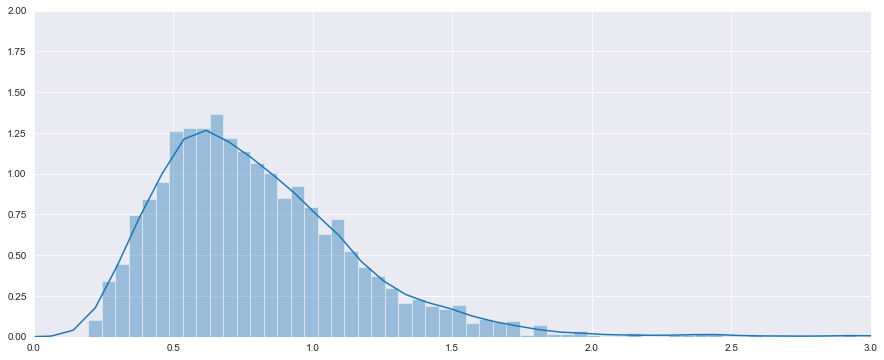

In [198]:
# sns.distplot(boar_teloFISH_df['TeloFISH'][0], bins=85, hist=True)

# sns.set_style('darkgrid')
# fig = plt.figure(figsize=(15,6)) # define plot area
# g = sns.distplot(boar_teloFISH_df['TeloFISH telos'][4], bins=200, hist=True)
# g.set(xlim=(0, 3))
# g.set(ylim=(0, 2))

In [ ]:
# sample_id_cleaned = []
# for row in boar_teloFISH_df['Sample ID']:
#     if '-' in row:
#         row = row.replace('-', '').replace(' ', '')
#         sample_id_cleaned.append(row)
#     else:
#         continue
# # sample_id_cleaned
# boar_teloFISH_df['Sample ID'] = sample_id_cleaned

In [ ]:
### DEPRECATED LINEAR REGRESSION EXAMPLE... PREFER TO USE SEABORN FOR THIS

# ext_dosage = aryn_teloPCR_cort_rad['External Dose (uSv)']
# ext_dosage = ext_dosage.values.reshape(-1, 1)

# cortisol = aryn_teloPCR_cort_rad['Cortisol (pg/mg)']
# cortisol = cortisol.values.reshape(-1, 1)

# linear_reg = linear_model.LinearRegression()
# linear_reg.fit(ext_dosage, cortisol)

# aryn_teloPCR_cort_rad.plot.scatter(x=['External Dose (uSv)'], y=['Cortisol (pg/mg)'])
# # plt.scatter(ext_dosage, cortisol,  color='black')
# plt.plot(ext_dosage, linear_reg.predict(ext_dosage), color='black', linewidth=1)
# # plt.xticks(())
# # plt.yticks(())
# # plt.show()

In [ ]:
### FINDING MISLABELED SAMPLES IN CORTISOL DATA 

#finding mislabeled samples
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def similarity_score(df, df2):
    score_dict = {}

    for row in df['Sample ID']:
        for row2 in df2['Sample ID']:
            score = similar(row, row2)
            score_dict[score] = [row, row2]
    for score, samples in score_dict.items():
        if score >= .5:
            print(samples)
            
# similarity_score(df, cortisol_df_samples)